In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os

from IPython.display import Image
from IPython.display import display

# numpy 1.23.5
import numpy as np

# pandas 1.5.3
import pandas as pd

# scikit-learn 1.2.2
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
# from cycler import cycler

# matplotlib  3.7.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [4]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [5]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [6]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [7]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [8]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [9]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [10]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [11]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [12]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""
        # TODO
        return np.mean((y*np.log(output+1e-8)+(1-y)*np.log(1-output+1e-8))*-1) 

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        return np.exp(z)/(np.exp(z)+1)

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        return np.where(self.activation(self.net_input(X))>=0.5,1,0)

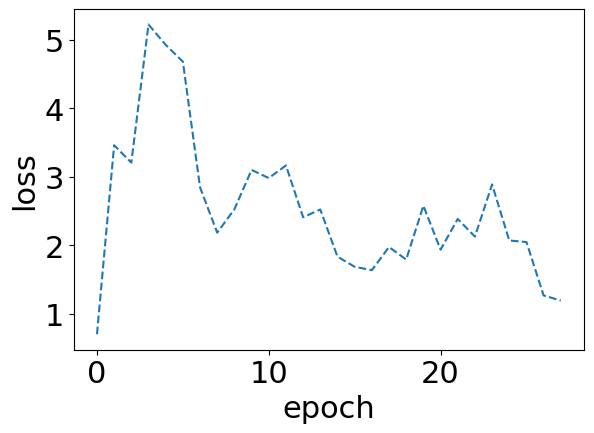

In [13]:
lgrs = LogisticRegression(n_epoch=28)
lgrs.fit(X_train_std,y_train)
plt.plot(lgrs.cost_, label='Loss Curve', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()

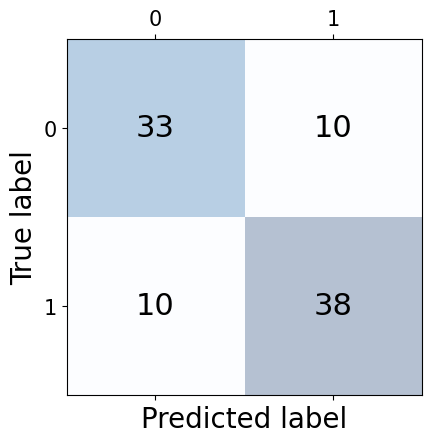

In [14]:
# plot confusion matrix
y_pred = lgrs.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

In [16]:
print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f' % (f[0], f[1]))
f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % f)


[F1-score]
Individual: 0.77, 0.79
Micro: 0.78
Macro: 0.78
